# Introduction and Overview

This notebook generates figures to accompany the OOI QC Data Guide, specifically
for the biooptical sensors built into the fluorometer triplet ('flort'). It begins
with a dataset for the Regional Cabled Array "Oregon Slope Base" shallow profiler, deployment 8. 
The time (Jan -- April 2021) is narrowed first to March 2021 and then to March 10, 2021. 


Circa 2022 the data download link is  
[here (NetCDF file)](/thredds/fileServer/ooigoldcopy/public/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/deployment0008_RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record_20210123T120000.228181-20210414T115959.167518.nc).
Alternatively, directions are given for finding the source full resolution data file under ***Data*** in the 
**`Notebooks/Ocean 05 A Programming Resources.ipynb`** of this repository. 


The full resolution source data file is over 500MB in size. As it does not fit in this repository,
it is placed in a parallel folder with relative path `../data/rca/fluor/osb/2021`. 


This notebook uses some 'helper' Python found in the `DataQualityGuideModule.py` module in this folder.
It is imported in the first Python cell below.

In [24]:
# Set up this notebook to use code from an accompanying Python module file
from DataQualityGuideModule import *
print('\nJupyter running Python {}'.format(sys.version_info[0]))


Jupyter running Python 3


# Preparation


The data within file `flort_fullres.nc` are assigned to the XArray Dataset variable `D`. It is then
slightly modified 
and the contents are examined. 

In [25]:
# open the dataset (chlor-a, fdom/cdom and backscatter) as variable 'D'
D = xr.open_dataset('../data/rca/fluor/osb/2021/flort_fullres.nc')

# substitute time for 'observation number' as the primary dimension
D = D.swap_dims({'obs':'time'})

# diagnostic: how many data values present
print('Number of data values: after file is opened, before time range narrowed to March 2021: ', len(D.time))

# narrow the time range to March 2021 (31 days, 86400 seconds per day: 2678400 samples
D = D.sel(time=slice(dt64('2021-03-01'), dt64('2021-04-01')))

# diagnostic: Number of data values after time window applied
print("Number of data values: March 2021 only, compare to 'one per second' total of 2678400: ", len(D.time))

# drop NaN values
D = D.dropna('time')

# diagnostic: Number of data values: after dropping NaNs
print('D number of data values after dropping NaN values is the same: ', len(D.time))

# rename the three sensor data streams; easier to read
D = D.rename( {'fluorometric_cdom':          'fdom',
               'fluorometric_chlorophyll_a': 'chlora',
               'optical_backscatter':        'backscatter'})


# reference D to produce a printout of its structure in terms of dimensions, coordinates, data values and attributes
# Dimensions: time only
# Coordinates: five; but time and depth (for the profiler) are the important ones. 
# Data variables: 39 total; where the three fluorometer channels will be renamed in the following cell
# Attributes: 68 total; ancillary metadata such as fluormeter model and manufacturer
D

Number of data values: after file is opened, before time range narrowed to March 2021:  5830998
Number of data values: March 2021 only, compare to 'one per second' total of 2678400:  2231042
D number of data values after dropping NaN values is the same:  2231042


<xarray.Dataset>
Dimensions:                                          (time: 2231042)
Coordinates:
    obs                                              (time) int32 2627967 ......
    lon                                              (time) float64 ...
    lat                                              (time) float64 ...
    depth                                            (time) float64 ...
  * time                                             (time) datetime64[ns] 20...
Data variables: (12/39)
    practical_salinity                               (time) float64 33.87 ......
    fluorometric_chlorophyll_a_qc_results            (time) uint8 12 12 ... 12
    fdom                                             (time) float64 1.3 ... 1...
    signal_3_offset                                  (time) float32 0.0 ... 0.0
    fluorometric_cdom_qc_executed                    (time) uint8 29 29 ... 29
    measurement_wavelength_cdom                      (time) float32 460.0 ......
    ...                                               ...
    total_volume_scattering_coefficient              (time) float64 9.269e-05...
    signal_2_offset                                  (time) float32 0.0 ... 0.0
    chlora                                           (time) float64 -0.0107 ....
    raw_internal_temp                                (time) float32 549.0 ......
    backscatter                                      (time) float64 0.0006074...
    fluorometric_cdom_qc_results                     (time) uint8 29 29 ... 29
Attributes: (12/68)
    node:                               SF01A
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  streamed
    stream:                             flort_d_data_record
    ...                                 ...
    geospatial_lon_max:                 -125.3896636
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

### Remark on QC flags

OOI provides a [web guide to QC flags](https://oceanobservatories.org/knowledgebase/interpreting-qc-variables-and-results/)
to help with their interpretation. Below we examine the first qc flag value for `fluorometric_cdom_qc_executed`
This integer value (29) is interpreted as a series of binary flags (right to left) that tell which tests have been 
applied to the stream data.


In [26]:
# The very first 'cdom_qc_executed' flag in the dataset time series, in binary
bin(int(D.fluorometric_cdom_qc_executed[0]))

'0b11101'

Reading bits right to left: This indicates that tests 1, 3, 4 and 5 were completed. 
From the above web page these are respectively

```
1. global_range_test
2. dataqc_localrangetest: Not completed
3. dataqc_spiketest
4. dataqc_polytrendtest
5. dataqc_stuckvaluetest
6. dataqc_gradienttest: Not completed
```


As we will see, there are two extraneous data spikes in the FDOM/CDOM signal during March 2021. We would need to 
examine `fluorometric_cdom_qc_results` to see if these were picked up by the above qc tests. 

# Figure 1: Examine data

We begin with the simple plot function built into XArray DataArrays. The data time range was narrowed above to March 2021.
Some aberrant spikes are apparent in the FDOM (second chart).

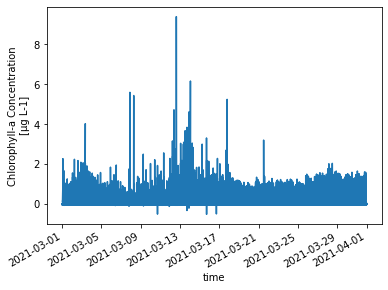

In [27]:
D.chlora.plot()              # Chlorophyll-A looks reasonable (with a few negative values apparent, however)

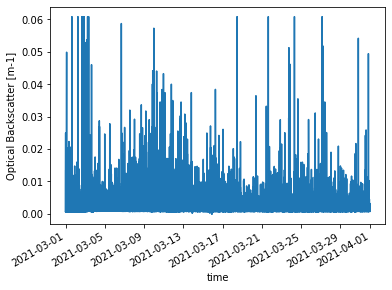

In [28]:
D.backscatter.plot()

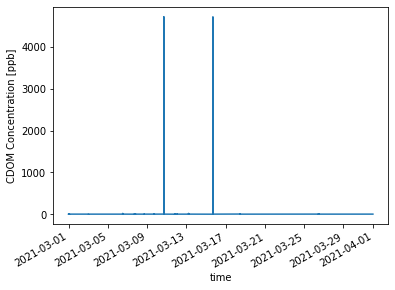

In [29]:
D.fdom.plot()               # FDOM/CDOM: Two clear spikes outside the typical data range

The FDOM/CDOM spikes in the third chart are clearly out of range. We now use the qc_result Data Variable for FDOM/CDOM to remove those data.
In particular, we will use the global_range_test qc flag (lowest order bit) as the discard criterion.
For this task we also select out a single day (March 10) at full resolution. At 1.2 samples per second this comes
to 72000 samples for one day. The `.sel` method is used to select out one day of data; and the `.where()` method
is used to drop data values where the global_range_test result is 0. (Time is UTC.)

March 10 number of data values:  71998  compared to 72000 per day at 1.2 seconds per sample.


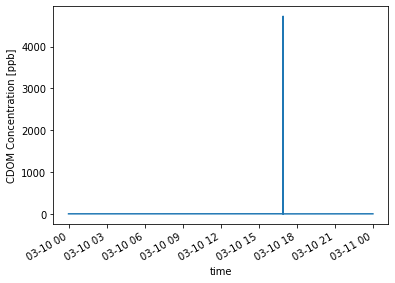

In [30]:
# Select out March 10 data to a new Dataset 'DMar10'
DMar10 = D.sel(time=slice(dt64('2021-03-10'), dt64('2021-03-11')))
print('March 10 number of data values: ', len(DMar10.time), ' compared to 72000 per day at 1.2 seconds per sample.')

# verify the spike is still present
DMar10.fdom.plot()

# Part 2: Drop data that did not pass the global range test

In [31]:
# Some example code is given (commented out) to indicate related operations.
#
# Code to show the first five qc results flags for FDOM/CDOM: 29, as seen above as well. 
# DMar10.fluorometric_cdom_qc_results[0:5]
# 
# Example of removing spike values using a threshold of 100; uses the .where() method.
# Dprime = DMar10.where(DMar10.fdom > 100., drop=True)

# Produce data subsets for March 10 that discard data where global_range_test is False.
DA = DMar10.where(DMar10.fluorometric_chlorophyll_a_qc_results % 2, drop=True)
DB = DMar10.where(DMar10.optical_backscatter_qc_results % 2,        drop=True)
DC = DMar10.where(DMar10.fluorometric_cdom_qc_results % 2,          drop=True)
print('Data sizes for source data and discards for chlora, backscatter and fdom:', len(DMar10.time), len(DA.time), len(DB.time), len(DC.time))

Data sizes for source data and discards for chlora, backscatter and fdom: 71998 30445 71998 71987


The other qc tests (higher order bits in the `_qc_results` flag) are considered 'of interest' at this time, but not grounds for 
dropping data. 

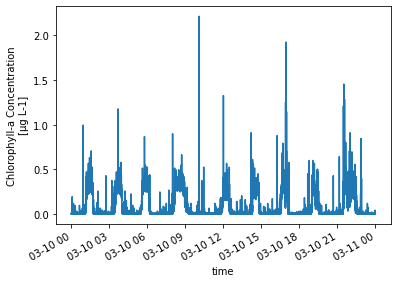

In [32]:
# Continuing with just March 10 2021: Chlor-A
DA.chlora.plot()

The scalloped appearance of this data is due to the nine daily ascent/descent cycles of the shallow profiler. It begins 
at a depth of about 200 meters and ascends to about 10 meters, then returns.

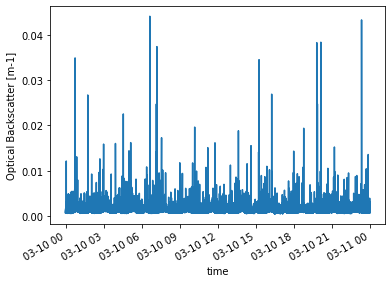

In [33]:
# Backscatter
DB.backscatter.plot()

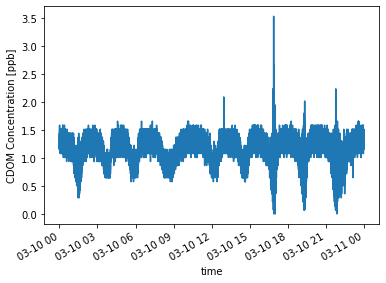

In [34]:
# FDOM/CDOM
DC.fdom.plot()

## Remark on sample timing


The 'observation' coordinate is a simple counter. The 'time' coordinate consists of timestamps.
The chart below shows sample time (vertical axis) versus observation number (horizontal axis).

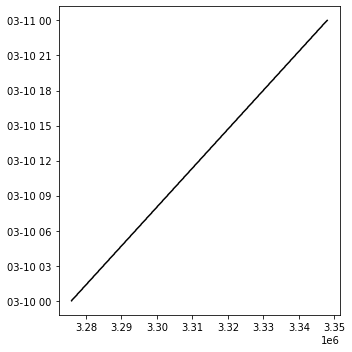

In [35]:
fig, axs = plt.subplots(figsize=(5, 5), tight_layout=True)
axs.plot(DA.obs, DA.time, color='k')

# Figure 3: Examine data

# Figure 4: Examine data

# Figure 5: Examine data

# Figure 6: Examine data